In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model
import torch
from torch import tensor

from sklearn.neighbors import NearestNeighbors

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from dadapy import id_estimation, Data

In [17]:
plt.rcParams.update({'font.size': 14})

In [18]:
# Define the model and the tokenizer
model = GPT2Model.from_pretrained("openai-community/gpt2")
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [40]:
#prompt = "Only the sky is the"
prompt = "One rainy evening, you receive a handwritten letter slid under your apartment door. It’s dated 1912 and addressed to someone with your exact name. The letter warns of a coming disaster and gives precise instructions to meet at an old clock tower that hasn't existed for over a century—at midnight. As thunder rumbles outside, your phone suddenly loses power, and strange symbols begin appearing on your walls, glowing faintly. You realize this letter wasn’t just meant for you—it’s been waiting. Why now? Who sent it? And what happens if you follow the instructions?"
#prompt = "In the year 2132, Earth is no longer the only home of humanity. After decades of exploration and colonization, humans have established settlements on Mars, several moons of Jupiter and Saturn, and even a floating city in the clouds of Venus. Technology has progressed to the point where artificial intelligence governs most civil operations, and the line between human and machine is blurrier than ever.Your protagonist, Kaelen Rho, is a hybrid—half-human, half-synthetic—created as part of a secret program to engineer beings capable of thriving in extreme environments. Kaelen has no memory of their early years, only fragments of coded dreams and flickers of forgotten voices. Raised on Titan by a collective of AI guardians, Kaelen has always known they were different, but the truth of their origin was kept hidden… until now.Following a sudden system failure that disables a critical communication relay between the outer colonies, Kaelen discovers a buried transmission hidden in the data logs—one that includes a name they've never heard but somehow recognize: Dr. Alira Voss. The message is heavily encrypted, but it’s clear the sender wanted Kaelen to find it. The message references something called “The Core Directive”—a protocol that, if activated, could permanently sever AI from human control or merge their consciousness into a shared network, forever altering the fabric of identity.Haunted by questions and pursued by unknown forces—both human and machine—Kaelen must leave the only home they’ve known and begin a journey across the solar system to uncover the truth about their creation, the nature of The Core Directive, and their role in an impending civil war that will force humanity to choose: evolution or extinction.As you write, consider these questions:What memories, real or implanted, shape Kaelen’s choices? How do other characters—human, AI, and hybrid—view Kaelen and their unique existence?What is The Core Directive, and who stands to gain or lose from it?How does Kaelen’s internal struggle mirror the broader tension between humanity and machine intelligence?Is the unification of organic and artificial consciousness a path to transcendence or a loss of self?Use sensory details to bring futuristic environments to life—from the icy methane rivers of Titan to the sleek, data-sheathed corridors of orbital AI habitats. Explore ethical dilemmas, emotional depth, and the fragility of identity in a world where memory can be manufactured and trust is a commodity."

inputs = tokenizer(prompt, return_tensors="pt")
print(inputs)

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True, return_dict=True)

print("\n")
print(outputs)

# Access model configuration
hidden_size = model.config.n_embd         # 768 
num_heads = model.config.n_head           # 12 
num_layers = len(model.h)                 # 12 
head_dim = hidden_size // num_heads       # 64

{'input_ids': tensor([[ 3198, 37259,  6180,    11,   345,  3328,   257, 45916,  3850, 27803,
           739,   534,  7962,  3420,    13,   632,   447,   247,    82, 14567,
         34463,   290,  9469,   284,  2130,   351,   534,  2748,  1438,    13,
           383,  3850, 22145,   286,   257,  2406,  9336,   290,  3607,  7141,
          7729,   284,  1826,   379,   281,  1468,  8801, 10580,   326,  5818,
           470, 11196,   329,   625,   257,  4289,   960,   265, 15896,    13,
          1081, 18355,   374, 25329,  2354,    11,   534,  3072,  6451, 14754,
          1176,    11,   290,  6283, 14354,  2221, 12655,   319,   534,  7714,
            11, 21377, 49057,    13,   921,  6537,   428,  3850,  2492,   447,
           247,    83,   655,  4001,   329,   345,   960,   270,   447,   247,
            82,   587,  4953,    13,  4162,   783,    30,  5338,  1908,   340,
            30,   843,   644,  4325,   611,   345,  1061,   262,  7729,    30]]), 'attention_mask': tensor([[1, 1, 1,

In [51]:
hidden_states = outputs.hidden_states
print(hidden_states[9].shape)
print(np.shape(hidden_states))

attentions = outputs.attentions
print(np.shape(attentions))

torch.Size([1, 120, 768])
(13, 1, 120, 768)
(12, 1, 12, 120, 120)


## Functions

In [20]:
def compute_SVD(M):
    # Center the data
    M = M - np.mean(M, axis=0, keepdims=True)
    _, sing_values, Vt = np.linalg.svd(M, full_matrices=False)

    eigenvalues = sing_values**2 
    eigenvectors = Vt.T

    return eigenvalues, eigenvectors

def eigenvectors_variance(M, cum=False):
    eigenvalues, _ = compute_SVD(M)

    tot_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues/tot_variance
    cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

    if cum==False: return explained_variance_ratio
    else: return explained_variance_ratio, cumulative_explained_variance_ratio

def components_for_threshold(explained_variance_ratio, threshold):
    return np.argmax(np.cumsum(explained_variance_ratio) >= threshold) + 1

"""def cosine_similarity_from_matrix(A, B):
    return cosine_similarity(A.flatten().reshape(1, -1), B.flatten().reshape(1, -1))[0, 0]"""

def grassmann_angle(A, B, threshold=.9):
    # Compute explained variance ratio (passing this function the matrices are centered)
    var_ratio_A = eigenvectors_variance(A)
    var_ratio_B = eigenvectors_variance(B)

    # Determine number of components for each
    kA = components_for_threshold(var_ratio_A, threshold)
    kB = components_for_threshold(var_ratio_B, threshold)
    k = min(kA, kB)

    # Project to top-k principal components
    Ua, _, _ = np.linalg.svd(A, full_matrices=False)
    Ub, _, _ = np.linalg.svd(B, full_matrices=False)
    A_proj = Ua[:, :k]
    B_proj = Ub[:, :k]

    # Principal angles
    M = A_proj.T @ B_proj
    _, cos_angles, _ = la.svd(M)

    arccos = np.arccos(cos_angles)
    return np.sqrt(np.sum(arccos**2))

In [21]:
def marchenko_pastur_filter(n ,d, buffer):
    """
    Function that considers only the meaningful eigenvalues according to Marchenko-Pastur distribution
    """
    ratio = d/n # threshold required from the distribution
    scaler = StandardScaler()
    buffer_scaled = scaler.fit_transform(buffer)
    sigma = 1.0 # variance of the scaled buffer

    # Define the Marchenko Pastur bounds
    lambda_min = sigma * (1 - np.sqrt(ratio))**2
    lambda_max = sigma * (1 + np.sqrt(ratio))**2
    
    # compute the covariance of the buffer scaled
    cov_buffer = np.cov(buffer_scaled, rowvar=False)
    eigenvalues = la.eigvalsh(cov_buffer)

    return eigenvalues[eigenvalues > lambda_max]

In [22]:
def QKV_spaces(model, inputs, block_idx):

    # Access a specific attention block
    attention_block = model.h[block_idx].attn

    # Extract attention weights
    with torch.no_grad():
        hidden_states = model(inputs.input_ids)[0]

        Q, K, V = attention_block.c_attn(hidden_states).split(hidden_states.size(-1), dim=-1)
        
        # Reshape for multi-head attention
        batch_size, seq_length, hidden_size = hidden_states.shape
        head_dim = hidden_size // model.config.n_head
        
        Q = Q.view(batch_size, seq_length, model.config.n_head, head_dim)
        K = K.view(batch_size, seq_length, model.config.n_head, head_dim)
        V = V.view(batch_size, seq_length, model.config.n_head, head_dim)
        
        return Q, K, V 

## Function testing

In [23]:
# Extract Q, K, V matrices

# Dictionary to store the results
qkv_dict = {}

# Loop over the layers
for layer in range(12):
    Q, K, V = QKV_spaces(model, inputs, layer)

    qkv_dict[layer] = {
        "layer": layer,
        "Q": Q, 
        "K": K,
        "V": V
    }

In [24]:
# Test
shapecheck = qkv_dict[0]["Q"]
Q0 = qkv_dict[0]["Q"].detach().numpy()[0, :, 0, :]
print(shapecheck.shape)

eigval, Vt = compute_SVD(Q0) # eigvec == Vt.t
var_ratio, cum_var = eigenvectors_variance(Q0, cum=True)
n_components = np.argmax(cum_var >= 0.90) + 1

Q_centered = Q0 - np.mean(Q0)
X_pca = Q_centered @ Vt[:, :n_components]

thresholds = 0.95
dims_needed = components_for_threshold(var_ratio, thresholds)
print("Dims needed: ", dims_needed)

# Try the PCA analysis
pca = PCA().fit(Q_centered)
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(explained_variance)
n_sklearn = np.argmax(cumulative_variance >= 0.9) + 1
print("Sklearn PCA:", n_sklearn)

torch.Size([1, 120, 12, 64])
Dims needed:  17
Sklearn PCA: 1


[17, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 4]
[7, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 6]
[11, 6, 5, 5, 6, 4, 6, 5, 6, 5, 4, 5]


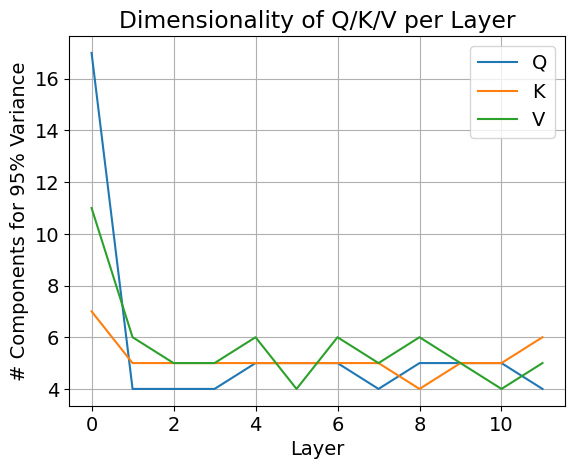

In [25]:
layers = model.config.n_layer
variance_threshold = .95
nQ = []
nK = []
nV = []

for l in range(layers):
    Q0 = qkv_dict[l]["Q"].detach().numpy()[0, :, 0, :]
    K0 = qkv_dict[l]["K"].detach().numpy()[0, :, 0, :]
    V0 = qkv_dict[l]["V"].detach().numpy()[0, :, 0, :]

    var_ratioQ = eigenvectors_variance(Q0)
    dims_neededQ = components_for_threshold(var_ratioQ, variance_threshold)
    nQ.append(dims_neededQ)

    var_ratioK = eigenvectors_variance(K0)
    dims_neededK = components_for_threshold(var_ratioK, variance_threshold)
    nK.append(dims_neededK)

    var_ratioV = eigenvectors_variance(V0)
    dims_neededV = components_for_threshold(var_ratioV, variance_threshold)
    nV.append(dims_neededV)

print(nQ)
print(nK)
print(nV)

# Visualization
plt.plot(range(layers), nQ, label='Q')
plt.plot(range(layers), nK, label='K')
plt.plot(range(layers), nV, label='V')
plt.xlabel("Layer")
plt.ylabel(f"# Components for {int(variance_threshold*100)}% Variance")
plt.title("Dimensionality of Q/K/V per Layer")
plt.legend()
plt.grid(True)
plt.show()

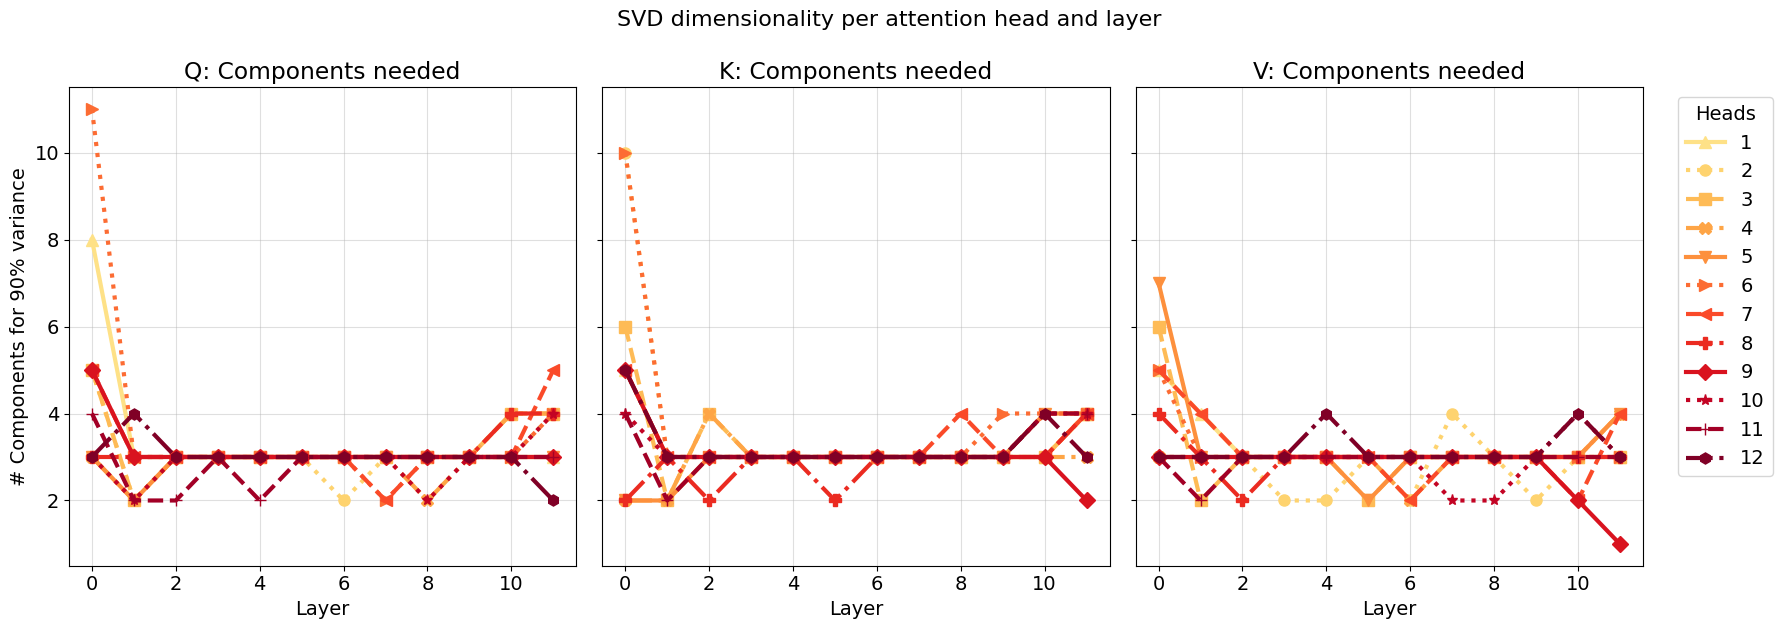

In [26]:
num_layers = model.config.n_layer
num_heads = model.config.n_head
variance_threshold = 0.9

nQ = [[0] * num_heads for _ in range(num_layers)]
nK = [[0] * num_heads for _ in range(num_layers)]
nV = [[0] * num_heads for _ in range(num_layers)]

for l in range(num_layers):
    for h in range(num_heads):
        # Extract Q, K, V for layer l, head h, and batch 0
        Q_lh = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]  
        K_lh = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]
        V_lh = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]

        # Compute explained variance ratio for each
        var_ratio_Q = eigenvectors_variance(Q_lh)
        var_ratio_K = eigenvectors_variance(K_lh)
        var_ratio_V = eigenvectors_variance(V_lh)

        # Components needed for threshold
        nQ[l][h] = components_for_threshold(var_ratio_Q, variance_threshold)
        nK[l][h] = components_for_threshold(var_ratio_K, variance_threshold)
        nV[l][h] = components_for_threshold(var_ratio_V, variance_threshold)



# ==================== Visualization ====================
heads = model.config.n_head
x = np.arange(layers)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, num_heads)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*", "+", "h"]
linestyles = ["solid", "dotted", "dashed", "dashdot"] * 3

# Q
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[0].plot(x, [nQ[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[0].set_title("Q: Components needed")
axs[0].set_xlabel("Layer")
axs[0].set_ylabel(f"# Components for {int(variance_threshold*100)}% variance")
axs[0].grid(alpha=0.4)

# K
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[1].plot(x, [nK[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[1].set_title("K: Components needed")
axs[1].set_xlabel("Layer")
axs[1].grid(alpha=0.4)

# V
for h in range(heads):
    color=colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[2].plot(x, [nV[l][h] for l in x], label=f'{h+1}', marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[2].set_title("V: Components needed")
axs[2].set_xlabel("Layer")
axs[2].grid(alpha=0.4)

# Optional: show legend only once
axs[2].legend(title="Heads", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("SVD dimensionality per attention head and layer", y=1.05, fontsize=16)
plt.show()

In [27]:
"""nQ = [[0] * num_heads for _ in range(num_layers)]
nK = [[0] * num_heads for _ in range(num_layers)]
nV = [[0] * num_heads for _ in range(num_layers)]

for l in range(num_layers):
    for h in range(num_heads):
        Q = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]
        K = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]
        V = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]

        # Centered matrices (important!)
        Qc = Q - np.mean(Q, axis=0)
        Kc = K - np.mean(K, axis=0)
        Vc = V - np.mean(V, axis=0)

        # Gram matrices
        Q_gram = Qc @ Qc.T
        K_gram = Kc @ Kc.T
        V_gram = Vc @ Vc.T

        # Explained variance from Gram matrices
        var_ratio_Q = eigenvectors_variance(Q_gram)
        var_ratio_K = eigenvectors_variance(K_gram)
        var_ratio_V = eigenvectors_variance(V_gram)

        nQ[l][h] = components_for_threshold(var_ratio_Q, variance_threshold)
        nK[l][h] = components_for_threshold(var_ratio_K, variance_threshold)
        nV[l][h] = components_for_threshold(var_ratio_V, variance_threshold)
        

# ==================== Visualization ====================
x = np.arange(num_layers)
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

cmap = plt.colormaps["YlOrRd"]
colors = [cmap(i) for i in np.linspace(0.2, 1, num_heads)]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*", "+", "h"]
linestyles = ["solid", "dotted", "dashed", "dashdot"] * 3

titles = ["Q", "K", "V"]
data = [nQ, nK, nV]

for idx, ax in enumerate(axs):
    for h in range(num_heads):
        ax.plot(x, [data[idx][l][h] for l in x],
                marker=markers[h % len(markers)],
                linestyle=linestyles[h % len(linestyles)],
                markersize=8, linewidth=3, color=colors[h])
    ax.set_title(f"{titles[idx]}: Components Needed")
    ax.set_xlabel("Layer")
    ax.grid(alpha=0.4)
    if idx == 0:
        ax.set_ylabel(f"# Components for {int(variance_threshold * 100)}% Variance")

ax.legend(title="Head", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.suptitle("PCA Dimensionality of Gram Matrices (Token Space)", y=1.05, fontsize=16)
plt.show()"""

'nQ = [[0] * num_heads for _ in range(num_layers)]\nnK = [[0] * num_heads for _ in range(num_layers)]\nnV = [[0] * num_heads for _ in range(num_layers)]\n\nfor l in range(num_layers):\n    for h in range(num_heads):\n        Q = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]\n        K = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]\n        V = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]\n\n        # Centered matrices (important!)\n        Qc = Q - np.mean(Q, axis=0)\n        Kc = K - np.mean(K, axis=0)\n        Vc = V - np.mean(V, axis=0)\n\n        # Gram matrices\n        Q_gram = Qc @ Qc.T\n        K_gram = Kc @ Kc.T\n        V_gram = Vc @ Vc.T\n\n        # Explained variance from Gram matrices\n        var_ratio_Q = eigenvectors_variance(Q_gram)\n        var_ratio_K = eigenvectors_variance(K_gram)\n        var_ratio_V = eigenvectors_variance(V_gram)\n\n        nQ[l][h] = components_for_threshold(var_ratio_Q, variance_threshold)\n        nK[l][h] = components_for_threshold(var_ra

In [28]:
"""# Compute the cosine similarity between Q, K and V spaces for each head
num_layers = model.config.n_layer
num_heads = model.config.n_head

thetaQK = [[0] * num_heads for _ in range(num_layers)]
thetaQV = [[0] * num_heads for _ in range(num_layers)]
thetaKV = [[0] * num_heads for _ in range(num_layers)]

for l in range(num_layers):
    for h in range(num_heads):
        # Extract Q, K, V for layer l, head h, and batch 0
        Q_lh = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]  
        K_lh = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]
        V_lh = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]

        # Compute the cosine similarity and store it in the proper vectors
        thetaQK[l][h] = cosine_similarity_from_matrix(Q_lh, K_lh)
        thetaQV[l][h] = cosine_similarity_from_matrix(Q_lh, V_lh)
        thetaKV[l][h] = cosine_similarity_from_matrix(K_lh, V_lh)



# ==================== Visualization ====================
heads = model.config.n_head
x = np.arange(layers)

fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharey=True)

colormap_name="winter"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 0.8, num_heads)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*", "+", "h"]
linestyles = ["solid", "dotted", "dashed", "dashdot"] * 3

# QK
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[0].plot(x, [thetaQK[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[0].set_title("QK orientation")
axs[0].set_ylabel("Cosine similarity")
axs[0].grid(alpha=0.4)

# QV
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[1].plot(x, [thetaQV[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[1].set_title("QV orientation")
axs[1].set_ylabel("Cosine similarity")
axs[1].grid(alpha=0.4)

# KV
for h in range(heads):
    color=colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[2].plot(x, [thetaKV[l][h] for l in x], label=f'{h+1}', marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[2].set_title("KV orientation")
axs[2].set_xlabel("Layer")
axs[2].set_ylabel("Cosine similarity")
axs[2].grid(alpha=0.4)

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Heads", loc='center right', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
plt.show()"""

'# Compute the cosine similarity between Q, K and V spaces for each head\nnum_layers = model.config.n_layer\nnum_heads = model.config.n_head\n\nthetaQK = [[0] * num_heads for _ in range(num_layers)]\nthetaQV = [[0] * num_heads for _ in range(num_layers)]\nthetaKV = [[0] * num_heads for _ in range(num_layers)]\n\nfor l in range(num_layers):\n    for h in range(num_heads):\n        # Extract Q, K, V for layer l, head h, and batch 0\n        Q_lh = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]  \n        K_lh = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]\n        V_lh = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]\n\n        # Compute the cosine similarity and store it in the proper vectors\n        thetaQK[l][h] = cosine_similarity_from_matrix(Q_lh, K_lh)\n        thetaQV[l][h] = cosine_similarity_from_matrix(Q_lh, V_lh)\n        thetaKV[l][h] = cosine_similarity_from_matrix(K_lh, V_lh)\n\n\n\n# ==================== Visualization ====================\nheads = model.config.n_head\nx = 

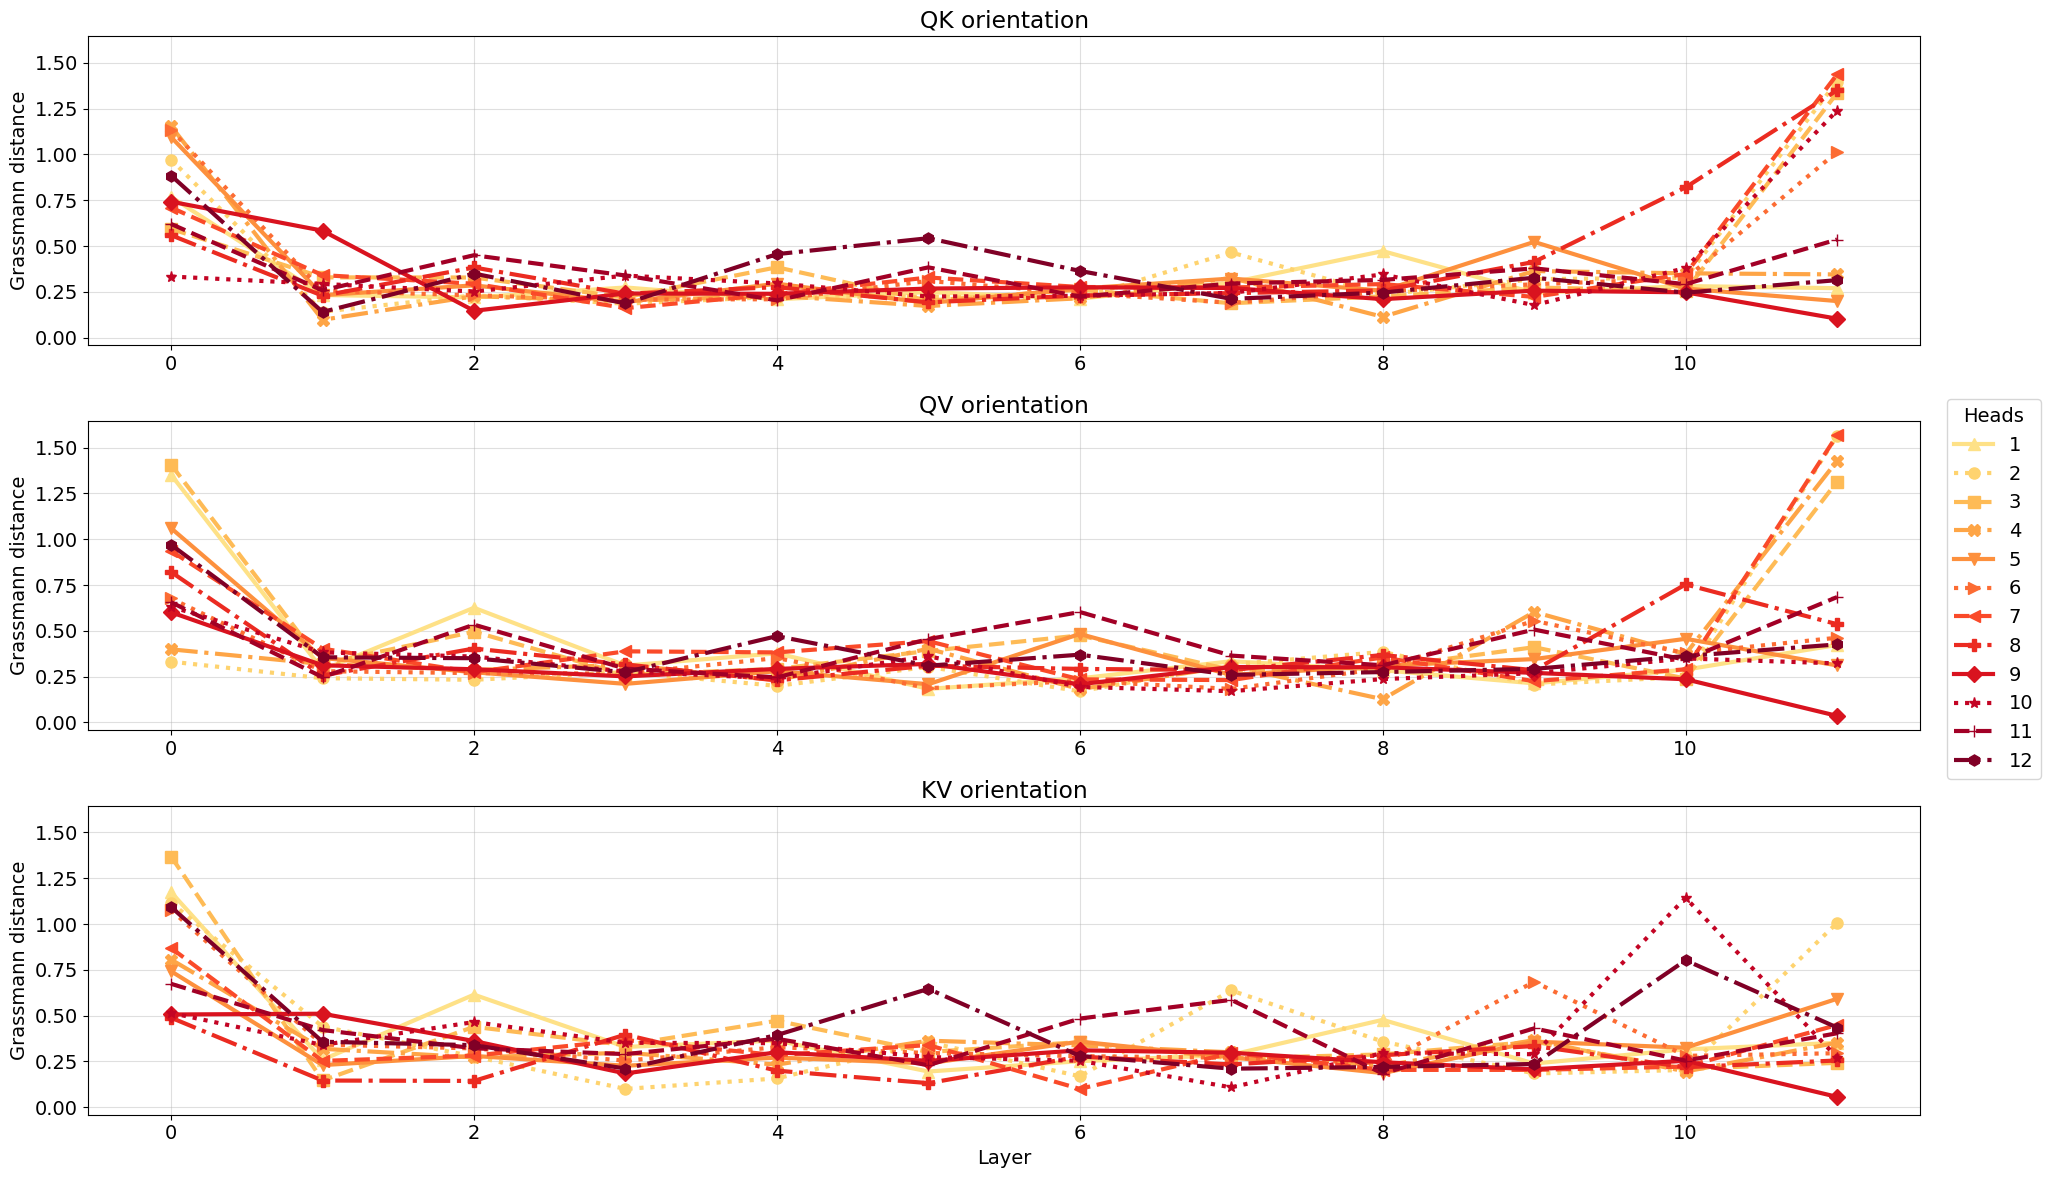

In [29]:
# Compute the orientation between Q, K and V spaces for each head
num_layers = model.config.n_layer
num_heads = model.config.n_head

thetaQK = [[0] * num_heads for _ in range(num_layers)]
thetaQV = [[0] * num_heads for _ in range(num_layers)]
thetaKV = [[0] * num_heads for _ in range(num_layers)]

for l in range(num_layers):
    for h in range(num_heads):
        # Extract Q, K, V for layer l, head h, and batch 0
        Q_lh = qkv_dict[l]["Q"].detach().numpy()[0, :, h, :]  
        K_lh = qkv_dict[l]["K"].detach().numpy()[0, :, h, :]
        V_lh = qkv_dict[l]["V"].detach().numpy()[0, :, h, :]

        # Compute the cosine similarity and store it in the proper vectors
        thetaQK[l][h] = grassmann_angle(Q_lh, K_lh)
        thetaQV[l][h] = grassmann_angle(Q_lh, V_lh)
        thetaKV[l][h] = grassmann_angle(K_lh, V_lh)


# ==================== Visualization ====================
heads = model.config.n_head
x = np.arange(layers)

fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharey=True)

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, num_heads)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*", "+", "h"]
linestyles = ["solid", "dotted", "dashed", "dashdot"] * 3

# QK
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[0].plot(x, [thetaQK[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[0].set_title("QK orientation")
axs[0].set_ylabel("Grassmann distance")
axs[0].grid(alpha=0.4)

# QV
for h in range(heads):
    color = colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[1].plot(x, [thetaQV[l][h] for l in x], marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[1].set_title("QV orientation")
axs[1].set_ylabel("Grassmann distance")
axs[1].grid(alpha=0.4)

# KV
for h in range(heads):
    color=colors[h]
    marker = markers[h % len(markers)]
    linestyle = linestyles[h % len(linestyles)]
    axs[2].plot(x, [thetaKV[l][h] for l in x], label=f'{h+1}', marker=marker, linestyle=linestyle, markersize=8, linewidth=3, color=color)
axs[2].set_title("KV orientation")
axs[2].set_xlabel("Layer")
axs[2].set_ylabel("Grassmann distance")
axs[2].grid(alpha=0.4)

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Heads", loc='center right', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
plt.show()